In [1]:
!pip install natsort

In [2]:
#import necessary libraries

import os
import cv2
import random
import itertools
from tqdm import tqdm
from pathlib import Path
from natsort import natsorted
from os import makedirs, listdir
from os.path import join, exists, isdir
from PIL import Image, ImageChops, ImageEnhance

import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.applications import (MobileNetV2, Xception, InceptionV3, EfficientNetB7, ResNet101, NASNetLarge, 
                                           VGG19, VGG16, DenseNet201)
from tensorflow.keras.applications import (mobilenet_v2, xception, inception_v3, efficientnet, resnet, nasnet, vgg19, 
                                           vgg16, densenet)

np.random.seed(2)
plt.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (8, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
class Config:
    CASIA1 = "../input/casia-dataset/CASIA1"
    CASIA2 = "../input/casia-dataset/CASIA2"
    autotune = tf.data.experimental.AUTOTUNE
    epochs = 30
    batch_size = 64
    lr = 1e-3
    name = 'xception'
    n_labels = 2
    image_size = (224, 224)
    decay = 1e-6
    momentum = 0.95
    nesterov = False

In [4]:
models = {
    'densenet': DenseNet201,
    'xception': Xception,
    'inceptionv3': InceptionV3,
    'effecientnetb7': EfficientNetB7,
    'vgg19': VGG19,
    'vgg16': VGG16,
    'nasnetlarge': NASNetLarge,
    'mobilenetv2': MobileNetV2,
    'resnet': ResNet101
}
# To use => myNet = models['densenet']() 

preprocess = {
    'densenet': densenet.preprocess_input,
    'xception': xception.preprocess_input,
    'inceptionv3': inception_v3.preprocess_input,
    'effecientnetb7': efficientnet.preprocess_input,
    'vgg19': vgg19.preprocess_input,
    'vgg16': vgg16.preprocess_input,
    'nasnetlarge': nasnet.preprocess_input,
    'mobilenetv2': mobilenet_v2.preprocess_input,
    'resnet': resnet.preprocess_input
}

# Computing error rate analysis

In [5]:
# source = https://stackoverflow.com/a/62010096/6118987
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

# Test on a Authentic image

In [6]:
"""Tensorflow format image encoding"""

# p = join(Config.CASIA2, 'Tp/')
# p = random_sample(p)

# img = tf.io.read_file(p)
# # img = tf.keras.preprocessing.image.load_img(p, target_size=(224, 224))
# # img = tf.keras.preprocessing.image.img_to_array(img)

# img = tf.image.decode_jpeg(img, channels=3)
# img = tf.image.resize(img, (224, 224))
# img = tf.cast(img, "uint8")

# compressed_img = tf.io.encode_jpeg(img, quality=95)
# compressed_img = tf.image.decode_jpeg(compressed_img, channels=3)

# diff = np.absolute(img.numpy() - compressed_img.numpy())
# # diff = tf.cast(diff, "float32")
# # absdiff = tf.math.abs(diff)
# plt.imshow(diff/255)

'Tensorflow format image encoding'

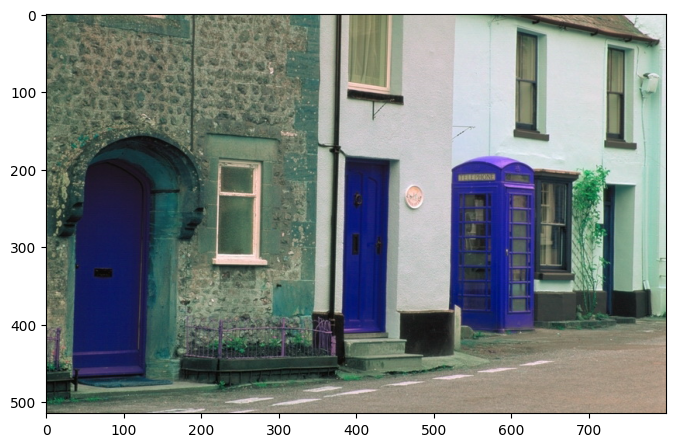

In [7]:
path = join(Config.CASIA2, 'Au/')
p = random_sample(path)
orig = cv2.imread(p)
plt.imshow(orig)
plt.show()

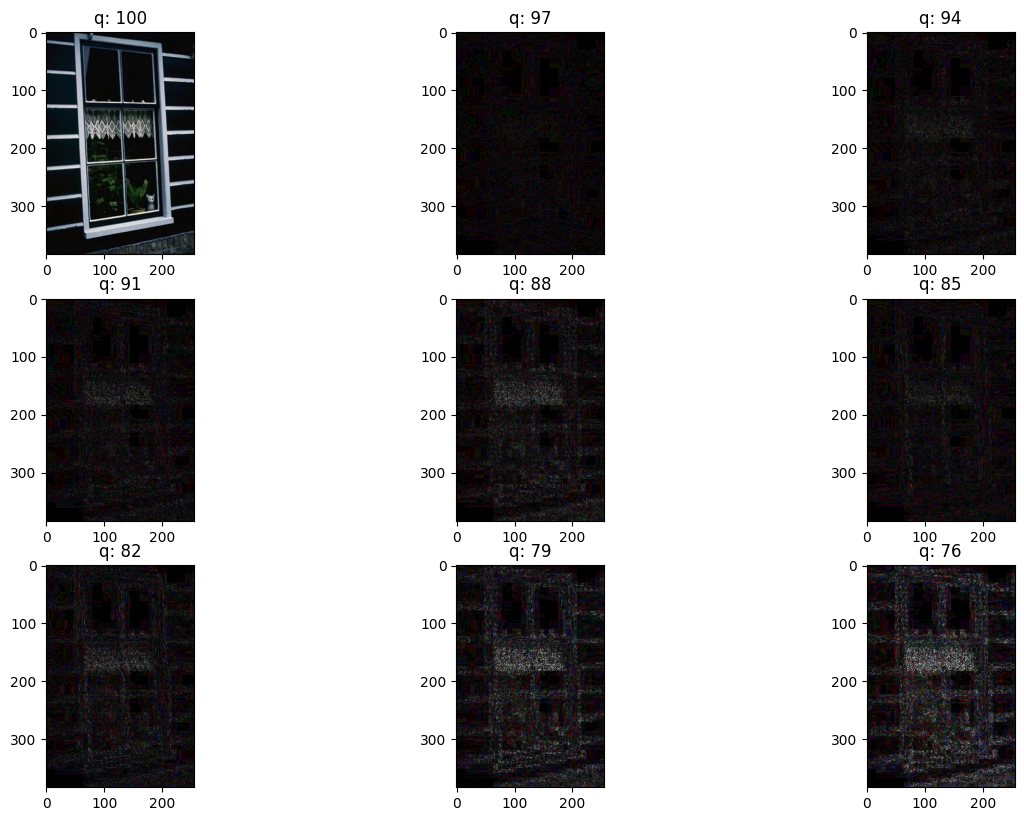

In [8]:
p = join(Config.CASIA2, 'Au/')
p = random_sample(p)
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 3
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

## Test on a tampered fake image

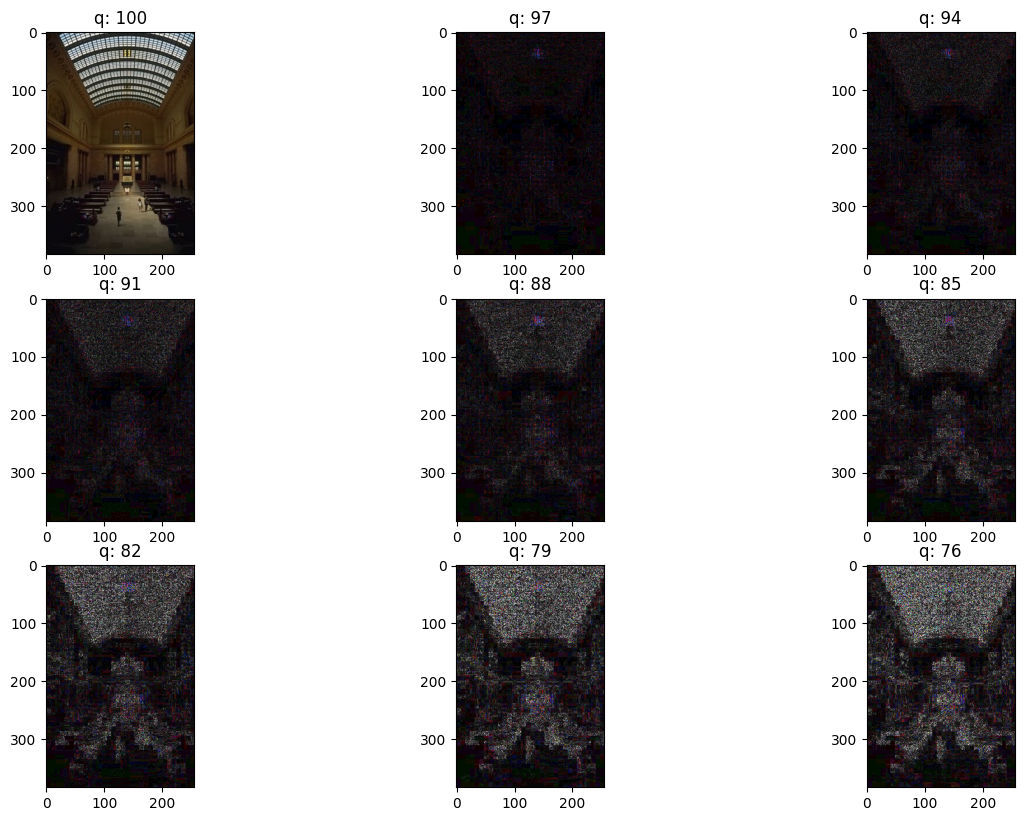

In [9]:
p = join(Config.CASIA2, 'Tp/')
p = random_sample(p)
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 3
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()## Test on a spliced fake image

## Test on a spliced fake image

In [10]:
# !ls ../input/casia-dataset/CASIA1/Sp | wc -l
# !ls ../input/casia-dataset/CASIA1/Au | wc -l

In [11]:
import albumentations as A
from albumentations import OneOf, Compose

@tf.function
def tensor_aug(img):
    img = tf.image.random_flip_left_right(img, 5)
    img = tf.image.random_flip_up_down(img, 5)
    return img

@tf.function
def batch_aug(images, labels):
    images = tf.map_fn(lambda img: tensor_aug(img), images)
    return images, labels

# def aug_flip(p=0.5):
#     return OneOf([
#         A.Flip(),
#         A.Transpose(),
#         A.RandomRotate90()
#     ],
#         p=p)

# def albumentation_aug(image, p=0.5):
#     augmented = Compose([aug_flip(p=1.0)],p=p)
#     result = augmented(image=image)
#     return result['image']

def ela_process(file_path):
    # https://www.tensorflow.org/guide/data
    QUALITY = 95
    SCALE = 15
    LABELS = np.array(['Au', 'Tp'])
    
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == LABELS
    # Integer encode the label
    label = tf.argmax(one_hot)
    label = tf.cast(label, tf.float32)
    
    # Generate the image
    orig = cv2.imread(file_path.numpy().decode('utf-8'))
    orig = cv2.resize(orig, (224, 224), interpolation = cv2.INTER_AREA)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    # Augmentation
#     orig = albumentation_aug(orig)
    # Save it in buffer
    _, buffer = cv2.imencode(".jpg", orig, [cv2.IMWRITE_JPEG_QUALITY, QUALITY])
    # get it from buffer and decode it to numpy array
    compressed_img = cv2.imdecode(np.frombuffer(buffer, np.uint8), cv2.IMREAD_COLOR)

    # Compute the absolute difference
    diff = SCALE * (cv2.absdiff(orig, compressed_img))
    img = preprocess[Config.name](diff)
    
    return img, label


In [12]:
jpg_pattern = '../input/casia-dataset/CASIA2/*/*jp*g'
tif_pattern = '../input/casia-dataset/CASIA2/*/*tif'

jpg_files = tf.data.Dataset.list_files(tif_pattern)
tif_files = tf.data.Dataset.list_files(jpg_pattern)

data_ds = jpg_files.concatenate(tif_files)

tensor_preprocess = lambda x: tf.py_function(ela_process, [x], [tf.float32, tf.float32])

n_data = data_ds.cardinality().numpy()
n_val = int(.2 * n_data)
data_ds = data_ds.shuffle(n_data)

train_ds = data_ds.skip(n_val).map(
    tensor_preprocess, num_parallel_calls=Config.autotune).batch(Config.batch_size).map(
    batch_aug, num_parallel_calls=Config.autotune)

val_ds = data_ds.take(n_val).map(
    tensor_preprocess, num_parallel_calls=Config.autotune).batch(Config.batch_size)

for img, label in train_ds:
    print(label)
    break

tf.Tensor(
[0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0.
 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(64,), dtype=float32)


## Check the generated images

## Utility functions for Training and Evaluations

In [13]:
from tensorflow.keras.layers import Dropout
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def create_model(optimizer, name='mobilenet', loss='categorical_crossentropy'):
    """
    Creates model based on the input name and freezes `blocks_to_train` blocks.
    Args: 
        optimizer(tf.keras.optimizers): initialized tensorflow optimizers.
        name(str): one of the keys in the `models` list.
        blocks_to_train: name of the blocks to freeze, if not given all the 
        layers will be trainable.
        loss: sets loss
        
    """
    
    base_model = models[name](include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    # model = Model(base_model.inputs, base_model.layers[-1].output)

    x = Flatten()(base_model.output)
#     x = Dense(1024, activation='relu')(x)
#     output = Dense(1, activation='sigmoid')(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(base_model.inputs, output)
    
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=METRICS)
    return model

def scheduler(epoch):
    if epoch % 25 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.9)
        
    return K.get_value(model.optimizer.lr)
def generate_path(path_to_output, last_run=False):
    """
    Creates new path and returns the address.
    Notes:
        Sometimes accidently it happens that you overwrite your previous models. so
        this function is designed to create a new path for each run.
    """
    if not isdir(path_to_output):
        makedirs(path_to_output)
    
    runs = natsorted([path for path in listdir(path_to_output) if path.startswith("run_tf_data")])
    if last_run:
        if not bool(runs):
            path = join(path_to_output, "run_tf_data_1")
        else:
            path = join(path_to_output, runs[-1])

        return path
    if not bool(runs):
        path = join(path_to_output, 'run_tf_data_1')
    else:
        f = runs[-1].rsplit("data_")[1]
        path = join(path_to_output, 'run_tf_data_' + str(int(f) + 1))
    
    return path

## Initializing the model

In [14]:
loss=tf.keras.losses.BinaryCrossentropy()
optimizer = Adam(lr=Config.lr)
"""
Model             Params
mobilenet           3M 
effecientnetb7      66M 
nasnetlarge         89M
inceptionv3         23M
xception            22M
resnet              44M
densenet            20M

"""


model = create_model(optimizer, name=Config.name, loss=loss)

# model.summary()

83689472/83683744 [==============================] - 3s 0us/step


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [16]:
path = generate_path('checkpoints')
weight_path = join(path, 'weights')
tensorboard_path = join(path, 'logs')

makedirs(weight_path)
makedirs(tensorboard_path)

ckpt = ModelCheckpoint(
    filepath=weight_path, 
    monitor='val_loss', 
    save_best_only=True,
    save_weights_only=True
)

tensorboard = TensorBoard(
    log_dir=tensorboard_path, 
    write_graph=True
)

reduce_lr = LearningRateScheduler(scheduler)


callbacks = [ckpt, 
#              reduce_lr, 
             tensorboard]

# Callbacks

In [17]:
path = generate_path('checkpoints')
weight_path = join(path, 'weights')
tensorboard_path = join(path, 'logs')

makedirs(weight_path)
makedirs(tensorboard_path)

ckpt = ModelCheckpoint(
    filepath=weight_path, 
    monitor='val_loss', 
    save_best_only=True,
    save_weights_only=True
)

tensorboard = TensorBoard(
    log_dir=tensorboard_path, 
    write_graph=True
)

reduce_lr = LearningRateScheduler(scheduler)


callbacks = [ckpt, 
#              reduce_lr, 
             tensorboard]

In [18]:

history = model.fit(
    train_ds,
    epochs=6,
    batch_size=Config.batch_size,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/6
156/156 [==============================] - 311s 2s/step - loss: 0.8332 - accuracy: 0.0058 - precision: 0.4313 - recall: 0.0391 - auc: 0.5021 - prc: 0.4223 - val_loss: 0.6772 - val_accuracy: 0.4103 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4995 - val_prc: 0.4092
Epoch 2/6
156/156 [==============================] - 255s 2s/step - loss: 0.6768 - accuracy: 0.0357 - precision: 0.2322 - recall: 4.2093e-04 - auc: 0.5140 - prc: 0.4187 - val_loss: 0.6757 - val_accuracy: 0.2821 - val_precision: 1.0000 - val_recall: 9.8619e-04 - val_auc: 0.5011 - val_prc: 0.4113
Epoch 3/6
156/156 [==============================] - 251s 2s/step - loss: 0.6433 - accuracy: 0.0166 - precision: 0.4529 - recall: 0.0185 - auc: 0.6081 - prc: 0.4993 - val_loss: 0.6599 - val_accuracy: 0.4872 - val_precision: 0.4586 - val_recall: 0.9933 - val_auc: 0.5790 - val_prc: 0.4601
Epoch 4/6
156/156 [==============================] - 266s 2s/step - loss: 0.3762 - accuracy: 0.0454 - precision: 0.8154 

# Evaluation

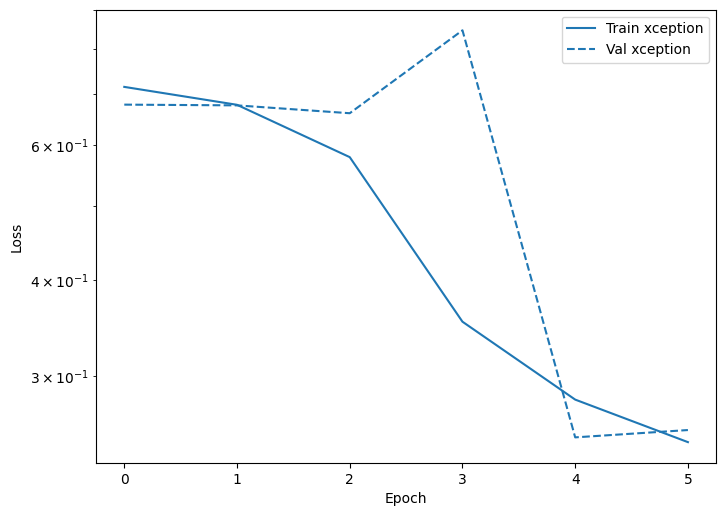

In [19]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#evaluate_metrics
# Plot loss

def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plot_loss(history, Config.name, 0)

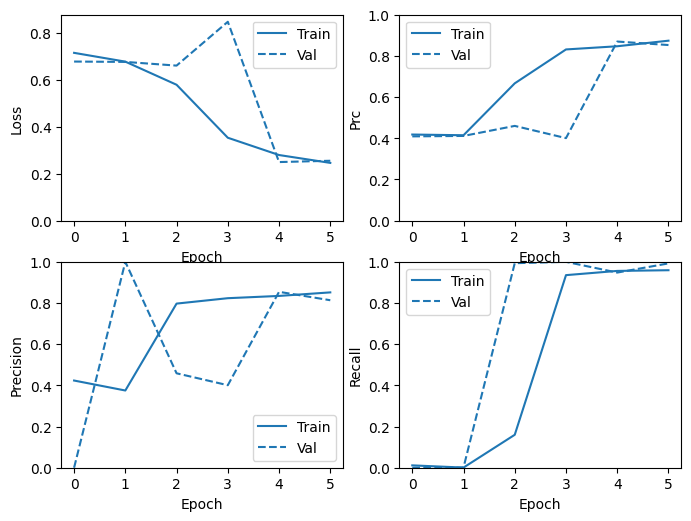

In [20]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],color=colors[0], 
                 linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

plot_metrics(history)

In [21]:
val_ds_x = []
val_ds_y = []

for _, (val_x_batch, val_y_batch) in enumerate(val_ds):
    for val_x, val_y in zip(val_x_batch, val_y_batch):
        val_ds_x.append(val_x)
        val_ds_y.append(val_y)

val_data = (tf.convert_to_tensor(val_ds_x, dtype=tf.float32), 
            tf.convert_to_tensor(val_ds_y, dtype=tf.float32))

In [22]:
val_data[0].numpy().shape

(2495, 224, 224, 3)

loss :  0.2561149001121521
accuracy :  1.0
precision :  0.8118577003479004
recall :  0.989402711391449
auc :  0.9422566890716553
prc :  0.8634335398674011



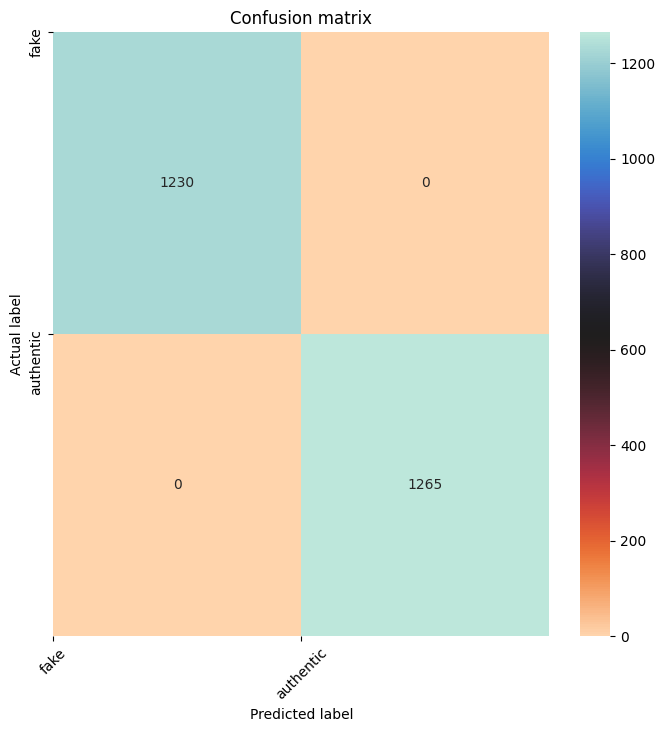

In [23]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#evaluate_metrics
# sns.color_palette("mako", as_cmap=True)
class_names = ['fake', 'authentic'] # make sure its correct

test_predictions_baseline = model.predict(val_data[0].numpy(), batch_size=Config.batch_size)

## CHECK
def plot_cm(label_matrix, predictions):
    
    preds = np.around(np.squeeze(predictions))
    gt = np.around(np.squeeze(predictions))
    
    cm = confusion_matrix(gt, 
                          preds,
                          labels=np.array([0, 1]))
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="icefire_r")
    indices = np.arange(len(class_names))
    plt.xticks(indices, class_names, rotation=45)
    plt.yticks(indices, class_names)
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

baseline_results = model.evaluate(val_data[0].numpy(), 
                                  val_data[1].numpy(),
                                  batch_size=Config.batch_size, 
                                  verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(val_data[1].numpy(), np.squeeze(test_predictions_baseline))

In [24]:
model.save_weights("weights_inc.h5")